# Matrix Approximation

In [2]:
import torch
import torch.nn as nn
from torch import optim
#from torchdiffeq import odeint_adjoint as odeint
from scipy.linalg import expm
from torchdiffeq import odeint
import numpy as np
import csv
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

### Defining essential functions

In [3]:
def dydt(y, t, A):
    return torch.mm(y,A)

In [4]:
def phi_A(y,A):
    return odeint(lambda t,x : dydt(x,t,A), y, torch.tensor([0., 1.]))[1]

### Neural ODE structure

In [5]:
class ODEFunc(torch.nn.Module):
    def __init__(self, A):
        super(ODEFunc, self).__init__()
        self.A = torch.nn.Parameter(torch.tensor(A))
        
    def forward(self, t, y):
        return dydt(y, t, self.A)

In [6]:
class NeuralODE(torch.nn.Module):
    def __init__(self, A_init):
        super(NeuralODE, self).__init__()
        self.func = ODEFunc(A_init)
        self.dim=len(A_init)
        self.hidden_layer = torch.nn.Linear(self.dim, 100)
        self.output_layer = torch.nn.Linear(100, self.dim*self.dim)
        
    def forward(self, y):
        y = self.hidden_layer(y)
        y = torch.relu(y)
        y = self.output_layer(y)
        return y
    
    def get_A(self):
        return self.func.A

## Training

In [10]:
def train_model(model, x_data,y_data,epochs=300, lr=0.05):
    training_loss=[]
    y_pred_list = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = odeint(model.func, x_data, torch.tensor([0., 1.]), method='dopri5')[1]
        loss = criterion(y_pred, y_data)
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            #print(f"Epoch {epoch}, Training Loss: {loss:.4f}")
            predict=torch.diag(neural_ode.get_A())
            #print(predict)
            training_loss.append(round(loss.detach().numpy().item(),3))
            y_pred_list.append(predict.detach().numpy())
    return training_loss,y_pred_list

### Parameters

In [54]:
dim = 10 #dimension of the matrix
mean = 1 #mean of the diagonal values
n_samples=10 #number of samples
stddevs=[i/10 for i in range(1,11)] #standard deviations from 0.1 to 1

In [55]:
#gaussian distribution for the x_i

x_data = torch.randn(n_samples, dim)

In [56]:
import numpy as np

data = {}

file_path = 'data.npy'
if os.path.exists(file_path):
    data = np.load(file_path, allow_pickle=True).item()

    
#getting results for each standard deviation
for stddev in tqdm(stddevs):
    print("déviation standard : ",str(stddev))
    
    diag = torch.from_numpy(np.random.normal(loc=mean, scale=stddev, size=dim).astype(np.float32))
    A_true = torch.diag(diag)
    print("matrice à viser : " , diag)

    y_data = phi_A(x_data, A_true)

    neural_ode = NeuralODE(np.eye(dim).astype(np.float32))
    training_loss,y_pred_list = train_model(neural_ode, x_data, y_data)
    A_estimated = neural_ode.get_A()
    frob_losses=np.linalg.norm((A_true-A_estimated).detach().numpy())

    key = str(stddev)
    data[key] = {'training_loss': training_loss, 'A_true': diag,'y_pred':y_pred_list,'frob':frob_losses}
    print(data[key])

np.save(file_path+'_'+str(n_samples), data)

  0%|          | 0/10 [00:00<?, ?it/s]

déviation standard :  0.1
matrice à viser :  tensor([1.2029, 1.0982, 1.0698, 0.9673, 0.9276, 0.9516, 0.7023, 0.8123, 1.2072,
        0.9655])


 10%|█         | 1/10 [00:14<02:11, 14.58s/it]

{'training_loss': [0.099, 0.009, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([1.2029, 1.0982, 1.0698, 0.9673, 0.9276, 0.9516, 0.7023, 0.8123, 1.2072,
        0.9655]), 'y_pred': [array([1.05      , 1.05      , 1.05      , 0.95000005, 0.95      ,
       0.95      , 0.95      , 0.95      , 1.05      , 0.95      ],
      dtype=float32), array([1.2044015 , 1.0966401 , 1.0494368 , 0.95480114, 0.9074599 ,
       0.9644226 , 0.62911034, 0.8076465 , 1.1694543 , 0.95066833],
      dtype=float32), array([1.208406  , 1.0996344 , 1.0525246 , 0.95286846, 0.93340594,
       0.9569504 , 0.7106175 , 0.8165179 , 1.2125275 , 0.9463755 ],
      dtype=float32), array([1.199341  , 1.0976335 , 1.0655371 , 0.96341014, 0.925391  ,
       0.9502975 , 0.7026523 , 0.8102702 , 1.2104807 , 0.9577819 ],
      dtype=float32), array([1.2019954 , 1.0975909 , 1.0704433 , 0.96634334, 0.92903197,
       0.9510435 , 0.69929034, 0.8106652 , 1.2091371 , 0.963585  ],
      dtype=float

 20%|██        | 2/10 [00:26<01:43, 12.99s/it]

{'training_loss': [0.285, 0.017, 0.003, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([0.9885, 0.9214, 1.1629, 0.9642, 1.2485, 1.1682, 0.9478, 0.9216, 0.7486,
        0.4949]), 'y_pred': [array([0.95000005, 0.95      , 1.05      , 0.95000005, 1.05      ,
       1.05      , 0.95000005, 0.95      , 0.95      , 0.95      ],
      dtype=float32), array([0.94991255, 0.92123973, 1.1278481 , 0.9299899 , 1.2513058 ,
       1.1820172 , 0.9348495 , 0.914581  , 0.69379437, 0.7650905 ],
      dtype=float32), array([0.9860095 , 0.9174931 , 1.148401  , 0.9302676 , 1.2531981 ,
       1.1667275 , 0.9483809 , 0.9208272 , 0.7501347 , 0.68712014],
      dtype=float32), array([0.98728347, 0.92106897, 1.1611367 , 0.9472435 , 1.2433933 ,
       1.1705759 , 0.9475418 , 0.91736746, 0.7519433 , 0.64865845],
      dtype=float32), array([0.98701996, 0.92167085, 1.1618013 , 0.9580784 , 1.2500231 ,
       1.1671447 , 0.9497219 , 0.9214734 , 0.74434894, 0.6155859 ],
      dtype=flo

 30%|███       | 3/10 [00:40<01:33, 13.36s/it]

{'training_loss': [0.539, 0.025, 0.004, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([0.8229, 0.9916, 0.6640, 0.9149, 0.5876, 0.3757, 0.8954, 1.3956, 0.4868,
        1.1746]), 'y_pred': [array([0.95      , 0.95000005, 0.95      , 0.95      , 0.95      ,
       0.95      , 0.95      , 1.05      , 0.95      , 1.05      ],
      dtype=float32), array([0.7660184 , 0.9782174 , 0.6890391 , 0.90009576, 0.6081239 ,
       0.5074604 , 0.8839815 , 1.3809996 , 0.39239013, 1.0603395 ],
      dtype=float32), array([0.8073582 , 0.9830849 , 0.6360679 , 0.88572985, 0.5195401 ,
       0.4281386 , 0.8940243 , 1.3854636 , 0.45650676, 1.0959173 ],
      dtype=float32), array([0.8276824 , 0.98861945, 0.6541883 , 0.8913165 , 0.5615488 ,
       0.41315043, 0.89417773, 1.3940661 , 0.5078694 , 1.135567  ],
      dtype=float32), array([0.8207545 , 0.991075  , 0.6538635 , 0.9079276 , 0.59160495,
       0.40250766, 0.89733976, 1.3949032 , 0.47729078, 1.1631179 ],
      dtype=flo

 40%|████      | 4/10 [00:54<01:21, 13.65s/it]

{'training_loss': [0.88, 0.053, 0.008, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([0.7232, 0.9844, 1.1791, 0.8499, 0.8786, 1.4664, 1.7024, 0.9790, 1.3170,
        0.8110]), 'y_pred': [array([0.95      , 0.95000005, 1.05      , 0.95      , 0.95      ,
       1.05      , 1.05      , 0.95000005, 1.05      , 0.95      ],
      dtype=float32), array([0.5170606 , 0.9552342 , 1.1130536 , 0.83757794, 0.71978885,
       1.3720536 , 1.6049734 , 0.939121  , 1.2997568 , 0.8665709 ],
      dtype=float32), array([0.69838375, 0.9852039 , 1.1640072 , 0.8095043 , 0.83196634,
       1.423072  , 1.717294  , 0.9588652 , 1.300688  , 0.79579663],
      dtype=float32), array([0.7191175, 0.9828584, 1.1676152, 0.8128902, 0.885163 , 1.4556806,
       1.6969049, 0.9722846, 1.311042 , 0.7896033], dtype=float32), array([0.71180665, 0.98318654, 1.1785296 , 0.8396279 , 0.86896044,
       1.4630451 , 1.7023288 , 0.97568184, 1.3156544 , 0.793094  ],
      dtype=float32), array([0.7

 50%|█████     | 5/10 [01:16<01:22, 16.55s/it]

{'training_loss': [3.036, 0.143, 0.053, 0.035, 0.029, 0.027, 0.024, 0.022, 0.02, 0.018, 0.016, 0.013, 0.009, 0.005, 0.002], 'A_true': tensor([ 0.8557,  0.6245,  1.4423,  0.9430,  0.7905, -0.1325,  1.2756,  1.1203,
         1.4962,  1.8905]), 'y_pred': [array([0.95, 0.95, 1.05, 0.95, 0.95, 0.95, 1.05, 1.05, 1.05, 1.05],
      dtype=float32), array([0.60871196, 0.48698786, 1.2360177 , 0.84995705, 0.58310235,
       0.3874037 , 1.2574795 , 1.0162241 , 1.4650495 , 1.4290161 ],
      dtype=float32), array([0.6672089, 0.5875481, 1.3049835, 0.6728633, 0.6276578, 0.2228352,
       1.2248224, 1.0533062, 1.403828 , 1.4033636], dtype=float32), array([0.63022906, 0.6185448 , 1.2897127 , 0.50817025, 0.67066836,
       0.15775813, 1.2415875 , 1.0278411 , 1.4291251 , 1.4102451 ],
      dtype=float32), array([0.65000725, 0.60946995, 1.2722684 , 0.41326723, 0.6668804 ,
       0.12047974, 1.2503915 , 1.0363448 , 1.4278791 , 1.4471803 ],
      dtype=float32), array([0.6662799 , 0.60902214, 1.2723464 , 0.

 60%|██████    | 6/10 [01:37<01:13, 18.36s/it]

{'training_loss': [4.736, 0.471, 0.148, 0.068, 0.049, 0.036, 0.022, 0.008, 0.003, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([ 2.0250, -0.4350,  2.1065,  0.1821,  0.6942,  0.9588,  0.7407,  0.7259,
         1.8779,  0.9356]), 'y_pred': [array([1.05, 0.95, 1.05, 0.95, 0.95, 0.95, 0.95, 0.95, 1.05, 0.95],
      dtype=float32), array([1.7693162 , 0.20506856, 1.6169538 , 0.38352698, 0.49197322,
       0.64405096, 0.3135036 , 0.4336112 , 1.7031957 , 0.8830179 ],
      dtype=float32), array([ 1.9360489 , -0.13900314,  1.7033018 ,  0.27201873, -0.0029551 ,
        0.8170387 ,  0.02873744,  0.44671318,  1.8672323 ,  0.8389639 ],
      dtype=float32), array([ 1.9907671 , -0.3096462 ,  1.8145579 ,  0.13404968, -0.09107327,
        0.86975116,  0.19907917,  0.5706312 ,  1.8475685 ,  0.8021162 ],
      dtype=float32), array([ 2.015272  , -0.3610976 ,  1.8890269 ,  0.02791774, -0.06743825,
        0.90832436,  0.24242546,  0.62781113,  1.8639333 ,  0.7747515 ],
      dtype=float32), array(

 70%|███████   | 7/10 [01:54<00:53, 17.77s/it]

{'training_loss': [1.539, 0.08, 0.02, 0.004, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([0.3439, 0.1602, 0.5680, 0.6238, 1.7025, 0.0095, 0.6862, 0.4041, 1.3793,
        0.8810]), 'y_pred': [array([0.95, 0.95, 0.95, 0.95, 1.05, 0.95, 0.95, 0.95, 1.05, 0.95],
      dtype=float32), array([0.40214264, 0.2578091 , 0.53571534, 0.6571127 , 1.4633682 ,
       0.3906119 , 0.52537364, 0.33567673, 1.3799529 , 0.8807571 ],
      dtype=float32), array([0.27234793, 0.07083259, 0.43040368, 0.6167204 , 1.6306915 ,
       0.2542906 , 0.56376475, 0.2790862 , 1.359742  , 0.8187604 ],
      dtype=float32), array([0.30555215, 0.09458359, 0.49989128, 0.5916989 , 1.6917393 ,
       0.18100974, 0.65322   , 0.35268295, 1.3669677 , 0.82025635],
      dtype=float32), array([0.33479294, 0.14235806, 0.5766711 , 0.58025044, 1.7029129 ,
       0.14261295, 0.6977277 , 0.3856623 , 1.3743926 , 0.8416785 ],
      dtype=float32), array([0.34763336, 0.16354853, 0.56502104, 0.5940381 , 1.6

 80%|████████  | 8/10 [02:12<00:35, 17.79s/it]

{'training_loss': [3.191, 0.291, 0.11, 0.045, 0.026, 0.017, 0.012, 0.007, 0.003, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([0.0691, 0.7871, 1.3216, 1.6843, 1.1813, 1.6774, 0.8876, 2.0248, 1.0015,
        1.1266]), 'y_pred': [array([0.95     , 0.95     , 1.05     , 1.05     , 1.05     , 1.05     ,
       0.95     , 1.05     , 1.0499996, 1.05     ], dtype=float32), array([0.32660994, 0.47089946, 1.0847012 , 1.4169636 , 0.89908063,
       1.338645  , 0.7402425 , 1.6866456 , 0.75402236, 1.033653  ],
      dtype=float32), array([0.06824338, 0.8393191 , 1.1454358 , 1.4582151 , 0.8430767 ,
       1.4331555 , 0.92985994, 1.8372297 , 0.7472727 , 0.86671054],
      dtype=float32), array([0.0530603 , 0.73273927, 1.2956976 , 1.4808275 , 0.99322516,
       1.5060678 , 0.8069216 , 1.9163259 , 0.8698518 , 0.7230747 ],
      dtype=float32), array([0.04108873, 0.7715299 , 1.3108016 , 1.4906503 , 1.054206  ,
       1.5671613 , 0.849775  , 1.9531668 , 0.8572384 , 0.65307033],
      dtype=float32)

 90%|█████████ | 9/10 [02:32<00:18, 18.41s/it]

{'training_loss': [3.489, 0.288, 0.046, 0.011, 0.005, 0.003, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0], 'A_true': tensor([ 1.7880,  1.7757, -0.5334,  0.7929,  1.8248,  0.1895,  1.3321,  0.7636,
         1.3419, -0.2869]), 'y_pred': [array([1.05, 1.05, 0.95, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95],
      dtype=float32), array([1.5427094 , 1.6649443 , 0.41797665, 0.5683407 , 1.5824642 ,
       0.3863465 , 1.132815  , 0.56071085, 1.3694913 , 0.5509532 ],
      dtype=float32), array([1.7698997 , 1.7881091 , 0.13764371, 0.7204885 , 1.6970698 ,
       0.22584665, 1.3078734 , 0.6777213 , 1.3361729 , 0.43329668],
      dtype=float32), array([ 1.7573466 ,  1.7716937 , -0.01818118,  0.6741534 ,  1.790979  ,
        0.18008938,  1.3158988 ,  0.73487115,  1.3208455 ,  0.36912438],
      dtype=float32), array([ 1.7783453 ,  1.775595  , -0.09494355,  0.69807285,  1.8279268 ,
        0.17649223,  1.3315313 ,  0.74929756,  1.333412  ,  0.31343755],
      dtype=float32), array([ 1.

100%|██████████| 10/10 [03:09<00:00, 18.93s/it]

{'training_loss': [13.096, 2.39, 0.87, 0.462, 0.309, 0.257, 0.23, 0.213, 0.202, 0.195, 0.19, 0.187, 0.185, 0.182, 0.18], 'A_true': tensor([ 0.9876,  2.1326,  1.2581,  2.1322,  1.4825,  1.1178,  0.9604,  1.3395,
         2.6914, -0.6009]), 'y_pred': [array([0.95000005, 1.05      , 1.05      , 1.05      , 1.05      ,
       1.05      , 0.95000005, 1.05      , 1.05      , 0.95      ],
      dtype=float32), array([0.4546147 , 1.7705348 , 0.63737744, 1.6129405 , 1.0884138 ,
       0.6526543 , 0.36816445, 0.9670662 , 1.8684055 , 0.52138436],
      dtype=float32), array([ 0.17441307,  2.1739085 ,  0.11165519,  1.7218581 ,  1.3370752 ,
       -0.03862625, -0.43590948,  0.69462985,  2.2811577 ,  0.3331431 ],
      dtype=float32), array([ 0.39375052,  2.0937684 , -0.01171336,  1.8661473 ,  1.4646063 ,
       -0.4139769 , -0.6992418 ,  0.5060864 ,  2.5037584 ,  0.20087725],
      dtype=float32), array([ 0.3218959 ,  2.129239  ,  0.13606381,  1.9347026 ,  1.5297838 ,
       -0.50810766, -0.7477519

# Loading and plotting data

## n_samples = 100

In [13]:
#loading the data trained
if os.path.exists(file_path):
    data = np.load(file_path, allow_pickle=True).item() 

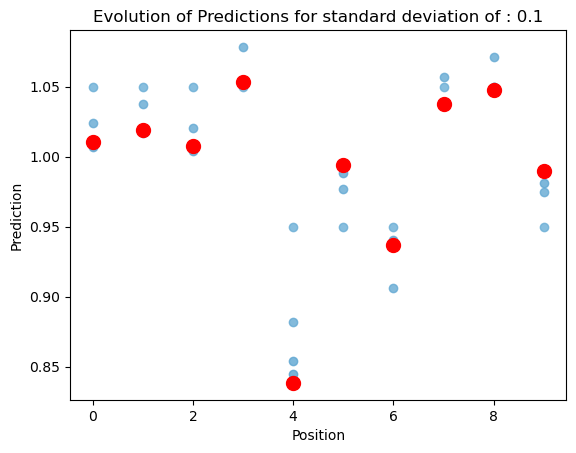

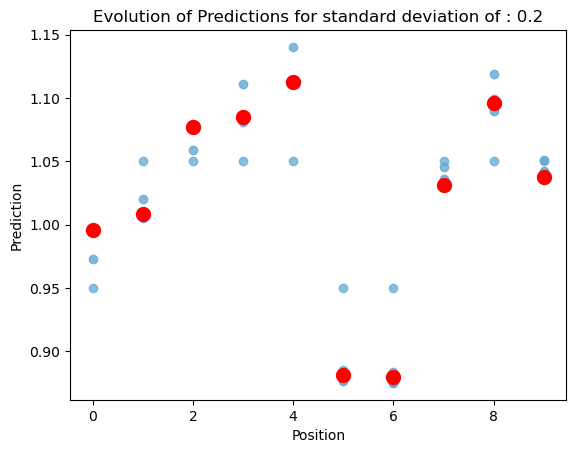

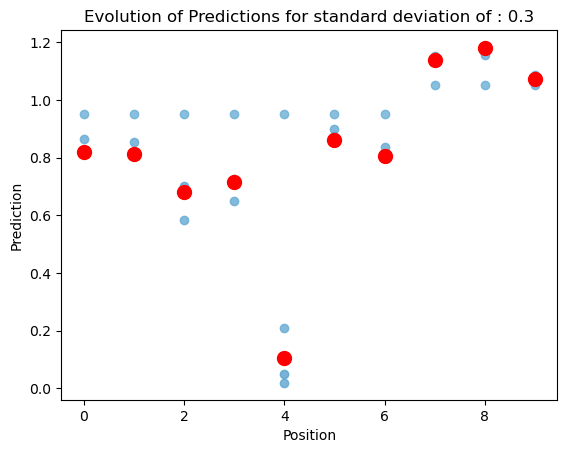

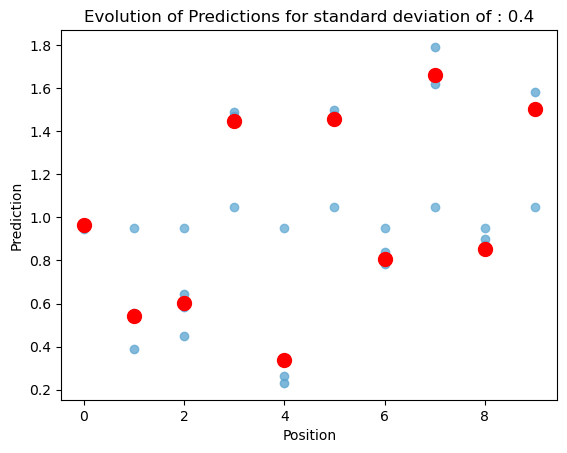

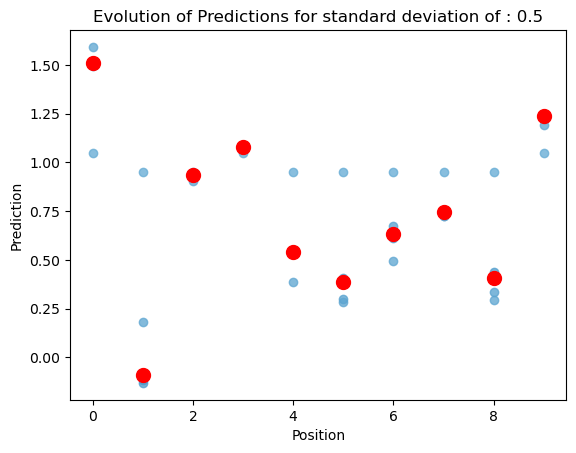

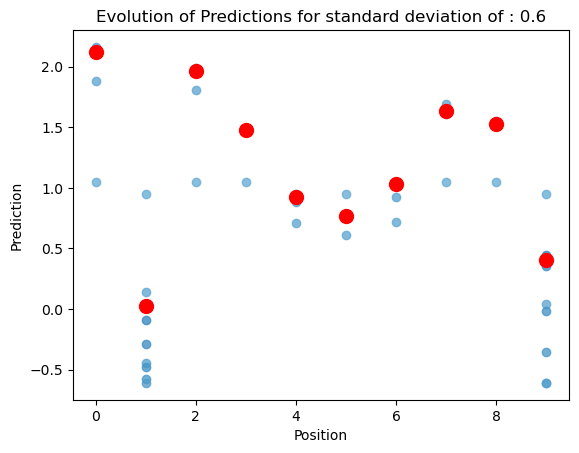

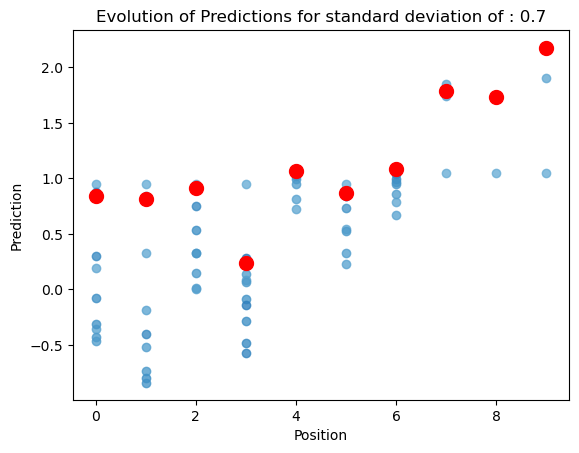

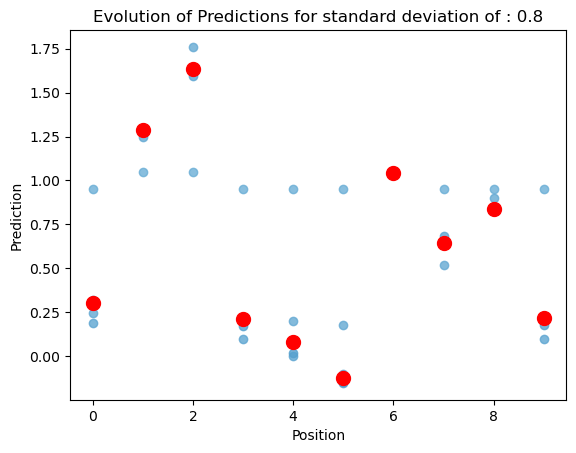

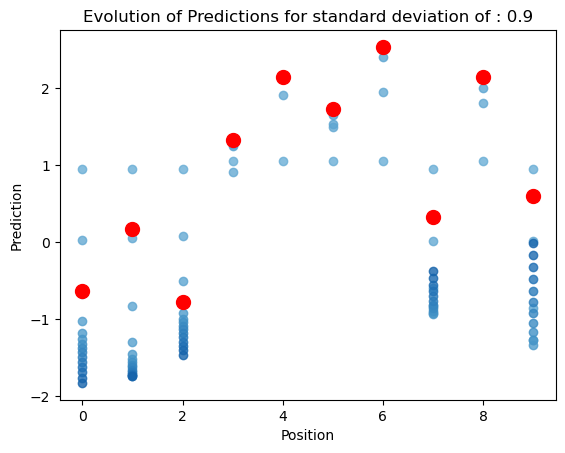

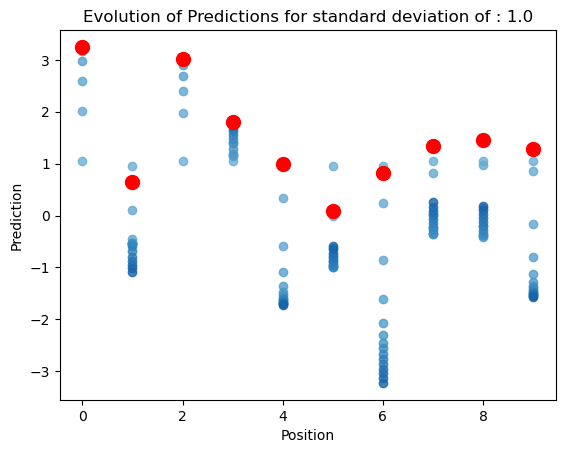

In [29]:
for stddev in stddevs:
    stddev=str(stddev)
    pred_array = data[stddev]['A_true']
    pred_list = data[stddev]['y_pred']

    # Generate the color gradient for pred_list
    colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(pred_list)))

    # Plot each prediction array
    for i, prediction in enumerate(pred_list):
        plt.scatter(range(len(prediction)), prediction, color=colors[i], alpha=0.8)

    # Plot each float in pred_array
    plt.scatter(range(len(pred_array)), pred_array, color='red', s=100)

    # Set axis labels and title
    plt.xlabel('Position')
    plt.ylabel('Prediction')
    plt.title('Evolution of Predictions for standard deviation of : ' + str(stddev))

    # Show the plot
    plt.show()

## Graph of losses

### Error loss

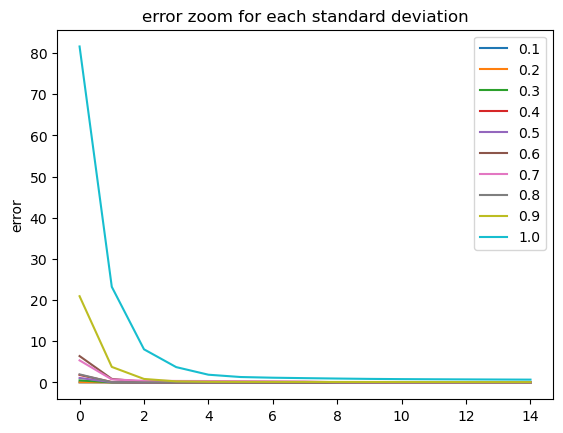

In [46]:
for stddev in stddevs:
    key=str(stddev)
    plt.plot(data[key]['training_loss'], label=key)

plt.title('error zoom for each standard deviation')
plt.ylabel('error')

plt.legend()
plt.show()

<b>Zooming</b>

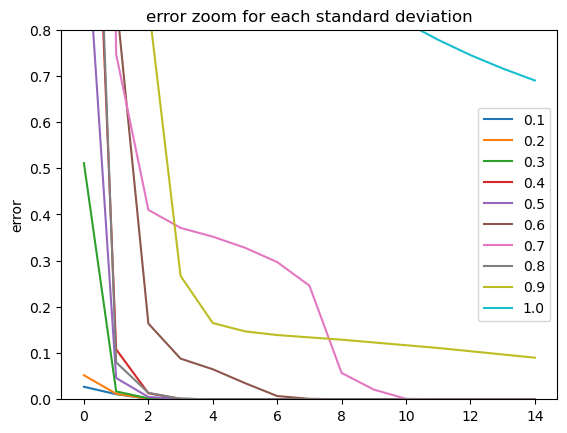

In [45]:
for stddev in stddevs:
    key=str(stddev)
    plt.plot(data[key]['training_loss'], label=key)

plt.title('error zoom for each standard deviation')
plt.ylabel('error')

plt.ylim(0,1)
plt.legend()
plt.show()

### Frobenius loss

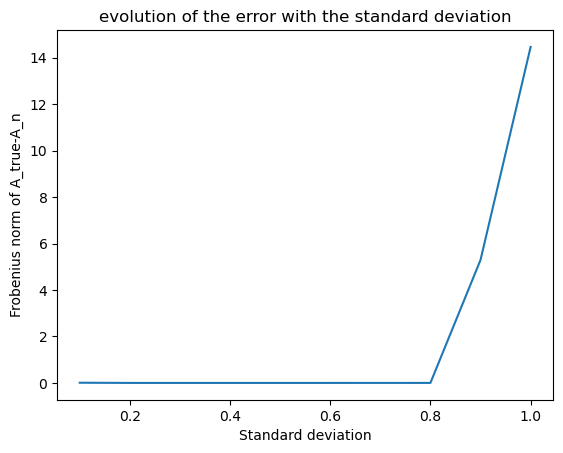

In [37]:
keys = stddevs
values = [data[str(stddev)]['frob'] for stddev in stddevs]

plt.plot(keys, values)
plt.title("evolution of the error with the standard deviation")
plt.xlabel('Standard deviation')
plt.ylabel('Frobenius norm of A_true-A_n')
plt.show()

## n_samples = 10

In [59]:
#loading the data trained
n_samples=10
if os.path.exists(file_path):
    data = np.load(file_path+'_'+str(n_samples)+'.npy', allow_pickle=True).item() 

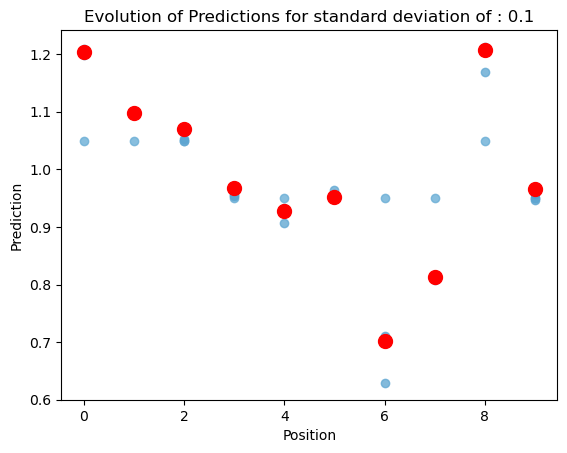

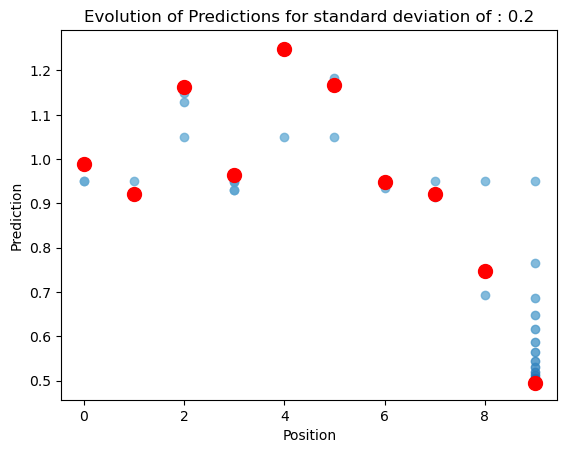

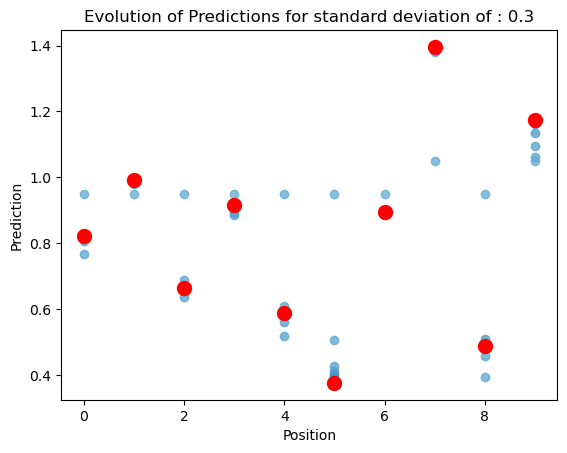

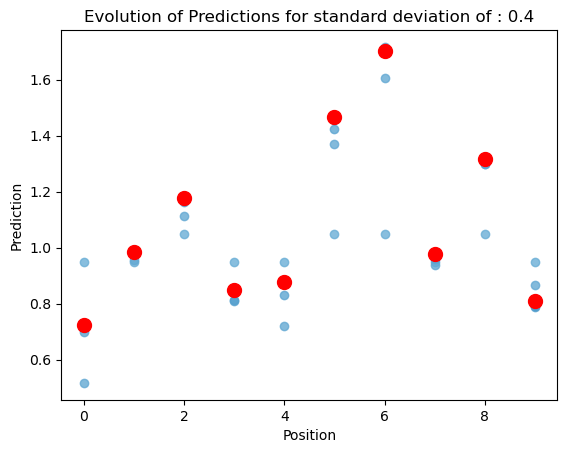

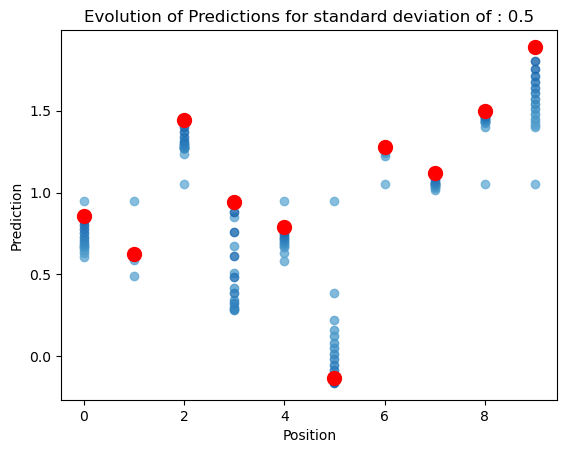

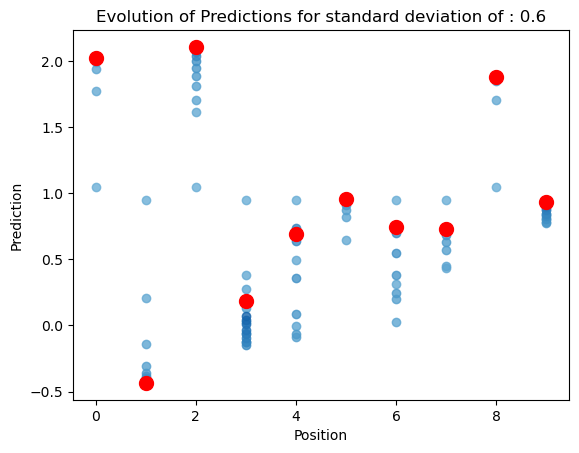

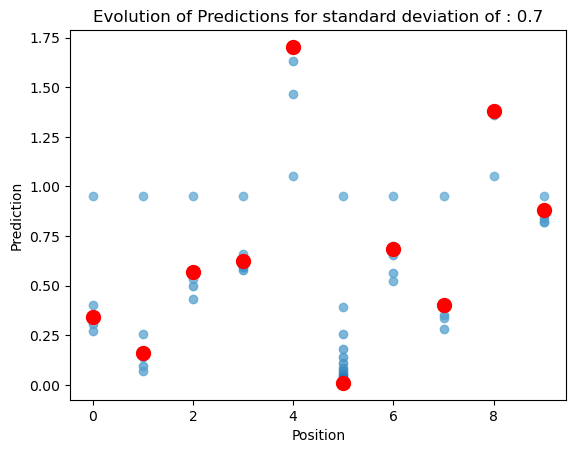

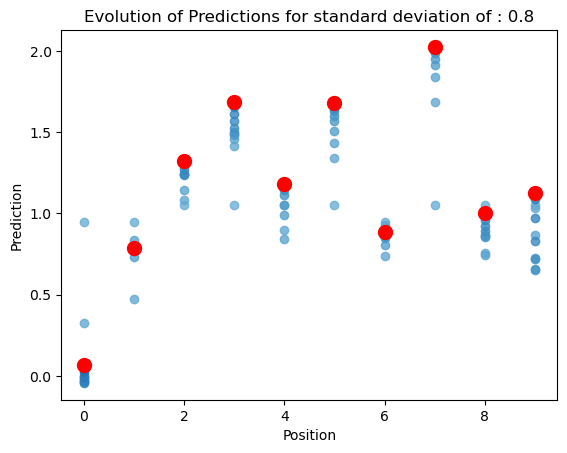

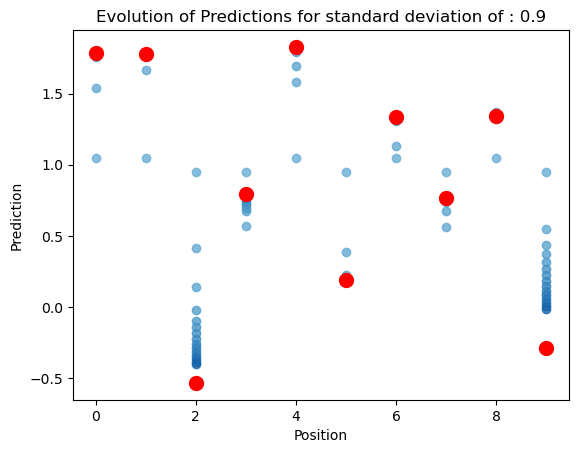

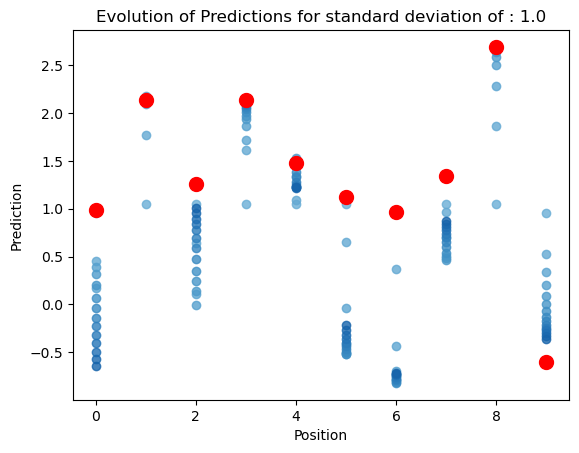

In [60]:
for stddev in stddevs:
    stddev=str(stddev)
    pred_array = data[stddev]['A_true']
    pred_list = data[stddev]['y_pred']

    # Generate the color gradient for pred_list
    colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(pred_list)))

    # Plot each prediction array
    for i, prediction in enumerate(pred_list):
        plt.scatter(range(len(prediction)), prediction, color=colors[i], alpha=0.8)

    # Plot each float in pred_array
    plt.scatter(range(len(pred_array)), pred_array, color='red', s=100)

    # Set axis labels and title
    plt.xlabel('Position')
    plt.ylabel('Prediction')
    plt.title('Evolution of Predictions for standard deviation of : ' + str(stddev))

    # Show the plot
    plt.show()

## Graph of losses

### Error loss

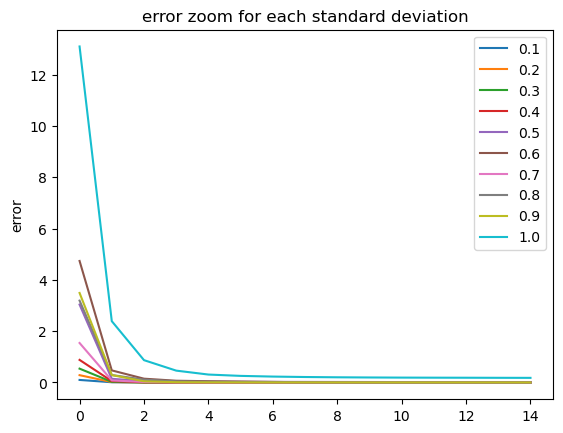

In [61]:
for stddev in stddevs:
    key=str(stddev)
    plt.plot(data[key]['training_loss'], label=key)

plt.title('error zoom for each standard deviation')
plt.ylabel('error')

plt.legend()
plt.show()

<b>Zooming</b>

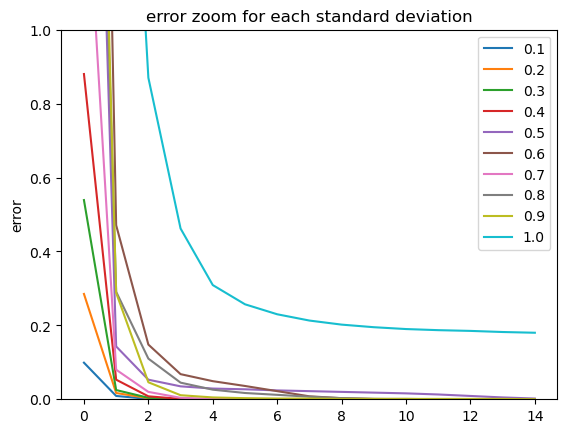

In [62]:
for stddev in stddevs:
    key=str(stddev)
    plt.plot(data[key]['training_loss'], label=key)

plt.title('error zoom for each standard deviation')
plt.ylabel('error')

plt.ylim(0,1)
plt.legend()
plt.show()

### Frobenius loss

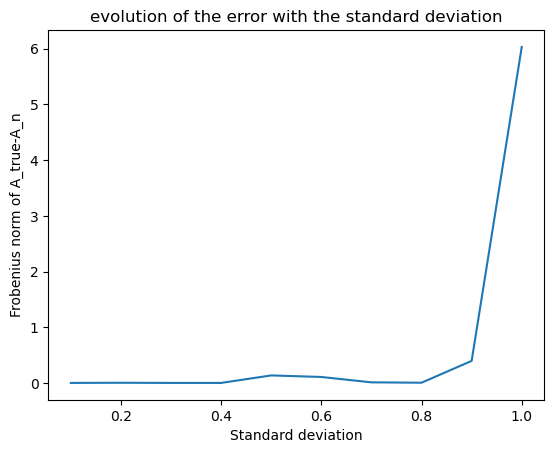

In [63]:
keys = stddevs
values = [data[str(stddev)]['frob'] for stddev in stddevs]

plt.plot(keys, values)
plt.title("evolution of the error with the standard deviation")
plt.xlabel('Standard deviation')
plt.ylabel('Frobenius norm of A_true-A_n')
plt.show()